In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv(r"C:\Users\user\Downloads\tedx_datase.csv")
print(df.head())


                                idx       main_speaker  \
0  8d2005ec35280deb6a438dc87b225f89     Alexandra Auer   
1  b3072cd11f40eb57fd259555264476c6  Elizabeth Gilbert   
2  4adc9fee977fa04c357ed4c9b52aa3cc       Butterscotch   
3  59c641a72b495d522a7932145d6c02b3         Ethan Lisi   
4  d227f2faf6ec185e54436d86463f499b      Daniel Finkel   

                                               title  \
0                    The intangible effects of walls   
1  It's OK to feel overwhelmed. Here's what to do...   
2                                  "Accept Who I Am"   
3               What it's really like to have autism   
4              Can you solve the sea monster riddle?   

                                             details           posted  \
0  More barriers exist now than at the end of Wor...  Posted Apr 2020   
1  If you're feeling anxious or fearful during th...  Posted Apr 2020   
2  Firing off her formidable beatboxing skills, m...  Posted Apr 2020   
3  "Autism is not a di

In [3]:
df.columns

Index(['idx', 'main_speaker', 'title', 'details', 'posted', 'url',
       'num_views'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4467 entries, 0 to 4466
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   idx           4467 non-null   object 
 1   main_speaker  4466 non-null   object 
 2   title         4467 non-null   object 
 3   details       4467 non-null   object 
 4   posted        4467 non-null   object 
 5   url           4467 non-null   object 
 6   num_views     209 non-null    float64
dtypes: float64(1), object(6)
memory usage: 244.4+ KB


In [5]:
df.describe()

,num_views
count,209.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [6]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [7]:
import matplotlib.pyplot as plt
import nltk
import warnings
import string
from scipy.stats import pearsonr
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download("stopwords")
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
df.isnull().sum()

idx                0
main_speaker       1
title              0
details            0
posted             0
url                0
num_views       4258
dtype: int64

In [9]:
splitted = df['posted'].str.split(' ', expand=True)

# create new columns
df['year'] = splitted[2].astype('int')
df['month'] = splitted[1]

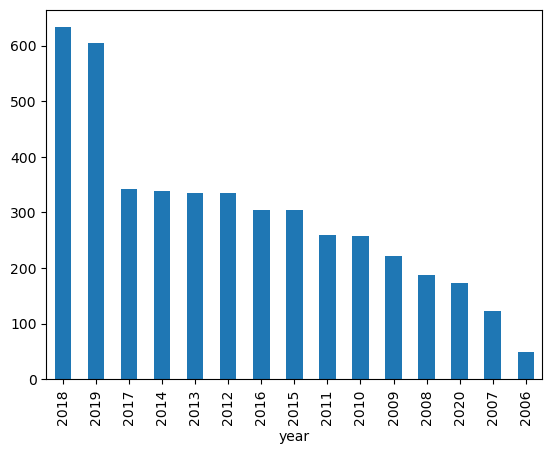

In [10]:

df['year'].value_counts().plot.bar()
plt.show()

In [11]:
df['details'] = df['title'] + ' ' + df['details']

df = df[['main_speaker', 'details']]
df.dropna(inplace=True)
df.head()


,main_speaker,details
0,Alexandra Auer,The intangible effects of walls More barriers ...
1,Elizabeth Gilbert,It's OK to feel overwhelmed. Here's what to do...
2,Butterscotch,"""Accept Who I Am"" Firing off her formidable be..."
3,Ethan Lisi,"What it's really like to have autism ""Autism i..."
4,Daniel Finkel,Can you solve the sea monster riddle? Accordin...


In [12]:
data = df.copy()


In [13]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    
    imp_words = []
    for word in str(text).split():
        word = word.lower()
        if word not in stop_words:
            imp_words.append(word)
    output = " ".join(imp_words)
    return output


In [14]:

df['details'] = df['details'].apply(lambda text: remove_stopwords(text))

df.head()

,main_speaker,details
0,Alexandra Auer,intangible effects walls barriers exist end wo...
1,Elizabeth Gilbert,ok feel overwhelmed. here's next feeling anxio...
2,Butterscotch,"""accept am"" firing formidable beatboxing skill..."
3,Ethan Lisi,"really like autism ""autism disease; another wa..."
4,Daniel Finkel,"solve sea monster riddle? according legend, ev..."


In [15]:

punctuations_list = string.punctuation

def cleaning_punc(text):
    signal = str.maketrans('', '', punctuations_list)
    return text.translate(signal)

df['details'] = df['details'].apply(lambda x: cleaning_punc(x))
df.head()

,main_speaker,details
0,Alexandra Auer,intangible effects walls barriers exist end wo...
1,Elizabeth Gilbert,ok feel overwhelmed heres next feeling anxious...
2,Butterscotch,accept am firing formidable beatboxing skills ...
3,Ethan Lisi,really like autism autism disease another way ...
4,Daniel Finkel,solve sea monster riddle according legend ever...


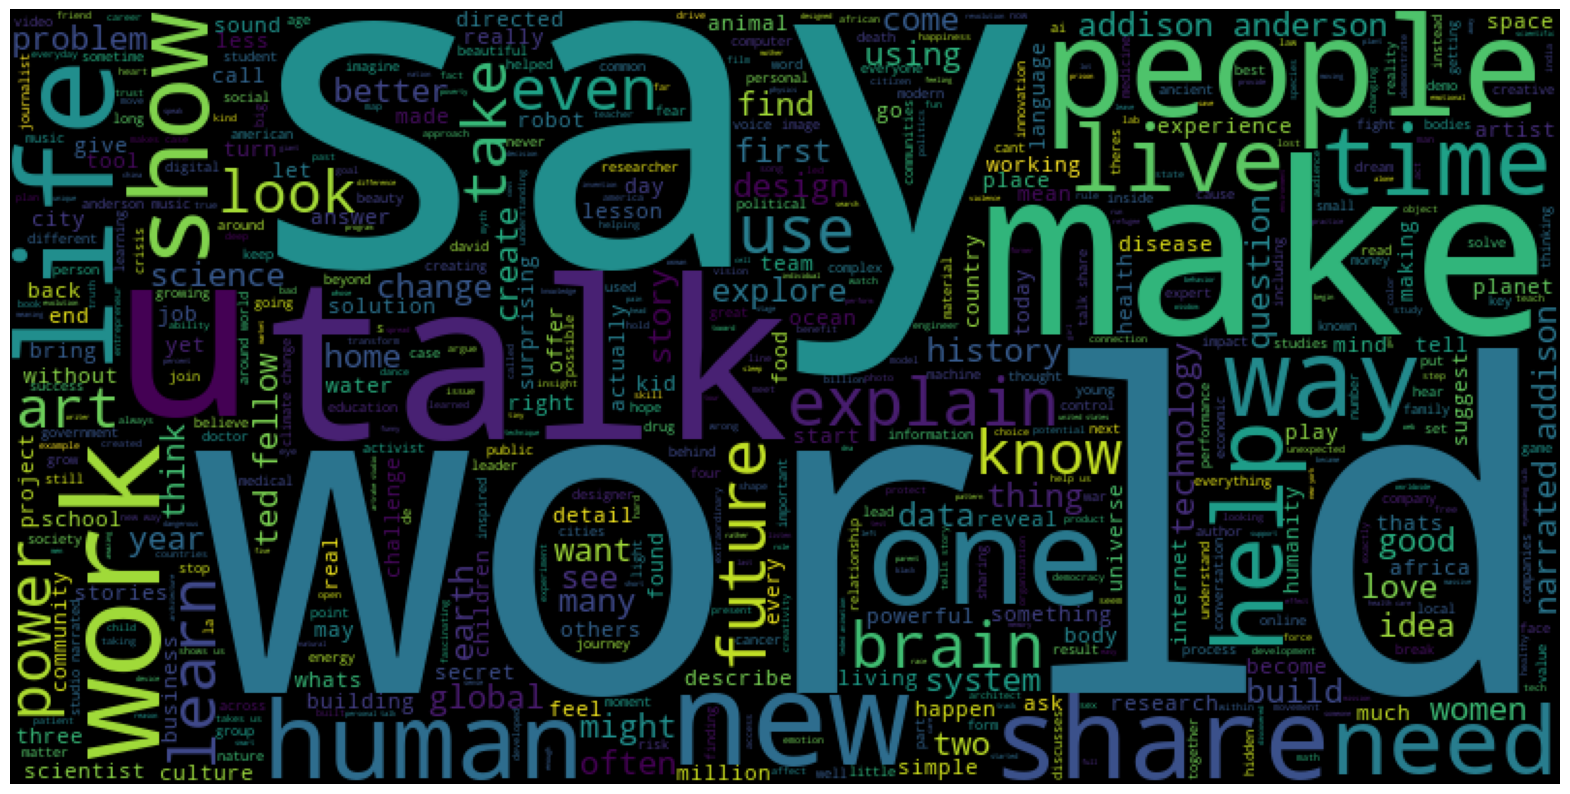

In [16]:
details_corpus = " ".join(df['details'])

plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000,
               width=800,
               height=400).generate(details_corpus)

plt.axis('off')
plt.imshow(wc)
plt.show()

In [17]:
vectorizer = TfidfVectorizer(analyzer = 'word')
vectorizer.fit(df['details'])

TfidfVectorizer()

In [18]:

df.head()

,main_speaker,details
0,Alexandra Auer,intangible effects walls barriers exist end wo...
1,Elizabeth Gilbert,ok feel overwhelmed heres next feeling anxious...
2,Butterscotch,accept am firing formidable beatboxing skills ...
3,Ethan Lisi,really like autism autism disease another way ...
4,Daniel Finkel,solve sea monster riddle according legend ever...


In [19]:
def get_similarities(talk_content, data=df):
    talk_array = vectorizer.transform(talk_content).toarray()
    sim = []
    pea = []
    for idx, row in data.iterrows():
        details = row['details']
        # get the vector for current talks
        talk_arrays = vectorizer.transform(
            data[data['details'] == details]['details']).toarray()
        # using as cosine sim
        cos_sim = cosine_similarity(talk_array, talk_arrays)[0][0]
        # pearson corr
        pea_sim = pearsonr(talk_array.squeeze(), talk_arrays.squeeze())[0]
        sim.append(cos_sim)
        pea.append(pea_sim)
    return sim,pea

In [20]:

def recommend_talks(talk_content, data=data):
    data['cos_sim'], data['pea_sim'] = get_similarities(talk_content)
    data.sort_values(by=['cos_sim', 'pea_sim'], ascending=[False, False], inplace=True)
    display(data[['main_speaker', 'details']].head())

In [21]:
talk_content = ['Time Management and working\
hard to become successful in life']

recommend_talks(talk_content)

,main_speaker,details
1758,Laura Vanderkam,How to gain control of your free time There ar...
2173,Philip Krinks,Finding your personal mission in life Philip K...
66,Fang Ruan,Management lessons from Chinese business and p...
1658,Chimamanda Ngozi Adichie,We should all be feminists We teach girls that...
3190,Nirmalya Kumar,India's invisible innovation Can India become ...
